# Behavioral Cloning Model Using LSTM


## Load Data

Load the Simulated data, instead of driving the car of simulator myself, I have used sample data provided by Udacity.

In [1]:
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os

path = "/home/anurag/carnd/CarND-Behavioral-Cloning-P3/data/"
timesteps = 10
lstmunits = 64

filenames = []
data = []
test_data = []

for filename in sorted(os.listdir(path+'center')):
        filenames += [filename]

with open(path+'log.csv') as f:
    csvreader = csv.reader(f)
    for v in csvreader:
        data.append(v)
    del csvreader

with open(path+'driving_log_validation.csv') as f:
    csvreader = csv.reader(f)
    for v in csvreader:
        test_data.append(v) 
    del csvreader
        
print("data imported")
print("data size:", len(data))
print(data[7913])

data imported
data size: 8036
['IMG/center_2016_12_01_13_46_29_398.jpg', ' IMG/left_2016_12_01_13_46_29_398.jpg', ' IMG/right_2016_12_01_13_46_29_398.jpg', ' -0.2971161', ' 0', ' 0.8110609', ' 8.243922']


## Visualize Data

View a sample from the dataset. Crop a smaple image and visualize how it looks to the car while driving.

(160, 320, 3)
(75, 320, 3)
3


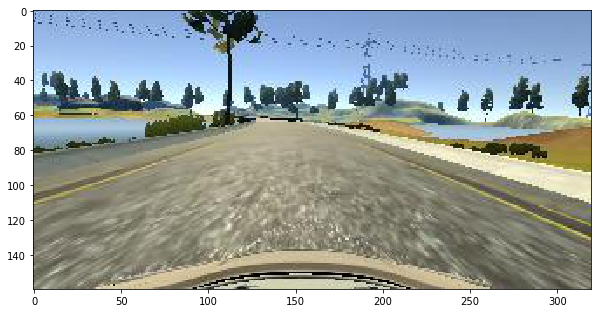

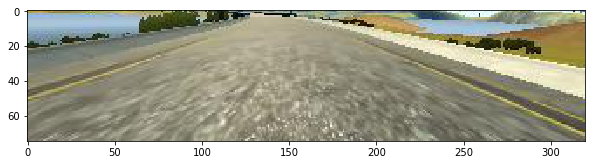

In [2]:
image = plt.imread(path+data[6000][0].strip())
print(image.shape)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.figure(figsize=(10,10))
image = image[60:135,:,:]
plt.imshow(image)
plt.figure(figsize=(10,10))
print(image.shape)
print (image.ndim)

## Import Data

Crop all the images from the dataset and import images and corresponding steering angles into seperate arrays. 

Also, the original data was split 80/20 randomly to test the trained model, the test data is loaded here as well. 

Finally, images from left and right cameras are loaded along with respective steering angles. A small correction is applied the steering angles for left and right images. 

The images are also flipped horizontally to augment data and to even out the distributions between left and right turns. Since the training data consists of a large number of frames with zero angle (driving straight) those frames are excluded while augmenting the data so that the model is trained evenly for driving staight as well as for driving while turning. 

(8036, 75, 320, 3)


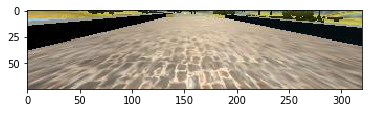

In [3]:
import numpy as np

X, X_test = [], []
y, y_test = [], []
timesteps = 10

#Read center-image, steering angle line by line from data:
for v in data:
    images = []
    image_read = cv2.imread(path+v[0].strip())
    images.append(image_read[60:135,:,:])  
    X += images
    steering = float(v[3])
    y += [steering] 
    
X = np.array(X)
y = np.array(y)
print (X.shape)
plt.imshow(X[0][...,::-1]) #convert BGR to RGB

## Training Data Generator
 
In some models, loading the entire dataset can cause GPU to go out of memory. In order to avoid that, the generator below creates batches of data for the model to consume. The batch size is assigned by the model.

In [4]:
def train_data_generator(batch_size, X, y):

    i = 0
    X_batch = np.empty([batch_size] + [timesteps] + list(X[0].shape))
    y_batch = np.empty([batch_size] + [timesteps] + [1])
    
    while(True):
        for batchidx in range(batch_size):
            X_batch[batchidx,0:-1,] = X_batch[batchidx,1:,]
            X_batch[batchidx,-1,]   = X[i+batchidx]
            y_batch[batchidx,0:-1,] = y_batch[batchidx,1:,]
            y_batch[batchidx,-1,]   = y[i+1+batchidx]
              
        i += batch_size
        if len(X) - i - 1 < batch_size:
            i = 0  

        yield X_batch, y_batch[:,-1,:] #(batch_size, timesteps, (img_shape)), (batch_size, 1, 1)

## Model



In [5]:
from keras.models import Sequential, model_from_json 
from keras.layers.core import Dense, Flatten, Dropout, Lambda 
from keras.layers.wrappers import TimeDistributed 
from keras.layers.recurrent import LSTM 
from keras.layers.convolutional import Conv2D 
from keras.layers.advanced_activations import ELU 
from keras.optimizers import Adam 
from keras import backend as K

input_shape = (timesteps,) + X[0].shape

model = Sequential()

model.add(TimeDistributed(Lambda(lambda x: x/127.5-1.0), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(filters=16, kernel_size=(8, 8), strides=(4, 4), padding='valid'))) 
model.add(TimeDistributed(ELU())) 
model.add(TimeDistributed(Dropout(0.10))) 
model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='valid'))) 
model.add(TimeDistributed(ELU())) 
model.add(TimeDistributed(Dropout(0.2))) 
model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='valid'))) 
model.add(TimeDistributed(ELU()))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(lstmunits, dropout=0.2, return_sequences=True, unroll=True)) 
model.add(LSTM(lstmunits, dropout=0.2, return_sequences=True, unroll=True)) 
model.add(LSTM(lstmunits, dropout=0.2, unroll=True))

model.add(Dense(100)) 
model.add(ELU()) 
model.add(Dropout(0.2)) 
model.add(Dense(10)) 
model.add(ELU()) 
model.add(Dropout(0.25)) 
model.add(Dense(1))

print(model.summary())

model.compile(optimizer=Adam(lr=1e-4), loss='mse')

history = model.fit_generator(train_data_generator(10, X, y), steps_per_epoch=804, epochs=5, verbose=1)

model.save_weights('./model.h5') 
json_string = model.to_json() 
with open('./model.json', 'w') as f: 
    f.write(json_string)

print("model saved")

K.clear_session()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 75, 320, 3)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 17, 79, 16)    3088      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 17, 79, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 17, 79, 16)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 7, 38, 32)     12832     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 7, 38, 32)     0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 10, 7, 38, 32)     0         
__________